<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab06_classification/timit-3.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 
# FRAME CLASSIFICATION using GMM's - PART II
_______________
## Model Optimization in function of database size and selected feature type

+ ###### Authors: Dirk Van Compernolle
+ ###### History:  04/2022, 17/03/2023, 05/03/2024, 18/02/2025
+ ###### Requires: pyspch v0.8  

### Content
- Training of GMMs for all phonemes
- Frame Classification
- Analysis of influence of database size, feature vector dimension, use of delta features, modeling detail (# gaussian components)
- Applying the models for utterance analysis

In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [31]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import requests
import importlib
import urllib.request
import pickle
import gzip

from sklearn import metrics as skmetrics 
from sklearn.neural_network import MLPClassifier
from IPython.display import display, HTML, Audio

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)
logging.basicConfig(level=logging.INFO)

# print and plot
mpl.rcParams['figure.figsize'] = [8.,8.]
mpl.rcParams['font.size'] = 12
np.set_printoptions(precision=3)
#cmap_jet2 = sns.mpl_palette("jet",60)[5:55]
colors=['b','r','g','k','c','m','y']
cmap = sns.color_palette(colors)
sns.set_palette(cmap)

# pyspch
import pyspch
from pyspch.stats import GMM
import pyspch.core as Spch

# 
from pyspch.core.utils_clf import train_GMM, train_MLP, test_clf
from pyspch.core.utils_timit import load_timit_data, print_dataset_statistics, select_subset

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

## SETTING UP
### LOAD THE TIMIT DATA

##### TIMIT database & Feature Extraction
In the next cell we load precomputed 24 dimensional mel filterbank features for TIMIT TRAIN and TEST sets.
We continue with following further processing steps:   
- mean and variance normalization per sentence
- addition of Delta features 
- conversion to 24D cepstral feature vector (including the delta's)

Finaly the data is restructured in a more convenient form for our classification experiments.
The data is stored as a long list of frames(feature vectors) with a corresponding list of labels.
The classes (set of all labels) are 41 phonetic symbols, i.e. the CMU-39 set + silence + closure.    

##### Some Background and Motivation 
- We use a low resolution (24 channel) MEL filterbank.  This is a good compromise between compactness (allowing for notebook experiments) and
performance which is more than good enough within the context of the intended experiments.
- Addition of Delta-Features have shown to be greatly beneficial for recognizers with frame based feature vectors
- Using mean and variance normalization of fragments of a few seconds (sentence or paragraph)  is a standard procedure that
 minimizes session-to-session veriability of the extracted features

In [4]:
def extract_Xy(data):
    X = data.get_features_as_numpy()
    y = data.get_labels_as_numpy()
    return(X,y)
#
alphabet = 'timit41'
timit41 = pyspch.timit.get_timit_alphabet('timit41')
ftrs = "mel24"  # "mfcc13", "mel24" or "mel80" are available
modify_feature_args = {"Norm":"meanvar","Deltas":"delta", "n_cep":24}
#
data = load_timit_data(corpus="train",ftrs=ftrs,alphabet=alphabet)
data.modify_features(modify_feature_args)
X_timit_train, y_timit_train = extract_Xy(data)
#
data = load_timit_data(corpus="test",ftrs=ftrs,alphabet=alphabet)
data.modify_features(modify_feature_args)
X_timit_test, y_timit_test = extract_Xy(data)

### Statistics For the TIMIT Database
These are the numbers for the TRAIN database:   
**#speakers**: **600**  
**#samples**: **1,417,087**   
Maximum number of samples per class:  **226,266**   
Minimum number of samples per class:    **1,218** 
Some example class statistics:  ('sil',226626), ('iy',62901), ('aa',37481), ('t',28720), ('ch',7116), ('zh',1218)   
Remark: these numbers are the number of frames for each phoneme, this is different from the phoneme occurrence in the database  ;  phoneme length varies roughly from 3 to 15 frames per occurrence.

You see that the data distribution is heavily skewed.
This is normal as frames were taken from random sentences and some phonemes are way more frequent than others.  
Moreover the average length of a phoneme plays a role; moreover long vowels will produce more frames per occurrence than a short plosive.
Some phonemes thus have thousands of examples available for training, while others (e.g. 'zh') are only marginally represented, e.g.     
The biggest class is 'sil' with 200k+ samples, the biggest phone classes are 's' and 'ih' with 80k+ samples.  The smallest classes are 'b', 'uh' and 'zh' with less than 5000 samples each.  Detailed counts per class are given below for TRAIN and TEST subsections.

In [120]:
print_dataset_statistics(y_timit_train,Details=True,txt="Train Database")
print_dataset_statistics(y_timit_test,Details=True,txt="Test Database")

Statistics for Train Database:
Number of classes 41
Number of samples 1417087
Minimun/Maximum number of samples per class:  1218  /  226626
[('aa', 37481), ('ae', 59237), ('ah', 39140), ('ao', 36404), ('aw', 11723), ('ay', 34376), ('b', 3823), ('ch', 7116), ('cl', 137933), ('d', 8158), ('dh', 10640), ('eh', 35133), ('er', 51761), ('ey', 28955), ('f', 22828), ('g', 6031), ('hh', 14142), ('ih', 84270), ('iy', 62901), ('jh', 7063), ('k', 25064), ('l', 43515), ('m', 24859), ('n', 46996), ('ng', 8513), ('ow', 26853), ('oy', 11024), ('p', 11482), ('r', 39609), ('s', 84491), ('sh', 25828), ('sil', 226626), ('t', 28720), ('th', 6862), ('uh', 4077), ('uw', 26444), ('v', 12033), ('w', 20946), ('y', 11322), ('z', 31490), ('zh', 1218)]
Statistics for Test Database:
Number of classes 41
Number of samples 517845
Minimun/Maximum number of samples per class:  643  /  81852
[('aa', 14133), ('ae', 21072), ('ah', 14948), ('ao', 14233), ('aw', 3751), ('ay', 12613), ('b', 1562), ('ch', 2244), ('cl', 48675)

### Code Base for The Experiments
The next cell defines the master routine **gmm_experiment()** that will be used for all experiments of frame based classification using a GMM classifier  
You may specify #gaussians, usage of Delta's, feature dimension, detailed priors ...   
This routine makes use of the base classifier routines in the pyspch package:
- **train_GMM()**: module for training Gaussian Mixture Models
- **test_clf()**: module for testing a classifier

Furthermore we will make use of some TIMIT specific routines:
- **select_subset()**: which allows for choosing only the examples belonging to a subset of class labels and also allows for downsampling

Here we also define 3 sets of categories that we will do experiments with:   
- **timit41**:  the full TIMIT database using 39 phonemic labels + SIL (silence) + CL (closure)
- **vowel6**:   6 long vowels spread well over the acoustic-phonetic space (vowel triangle)
- **plosives**: 6 plosive sounds

In [5]:
timit41 = pyspch.timit.get_timit_alphabet('timit41')
vowel6=['iy','aa','uw','ih','eh','er']
plosives=['p','t','k','b','d','g']
#
def gmm_experiment(X_train,y_train,X_test,y_test,ng=1,Deltas=True,nftrs="all",priors='training',Verbose=False):
    ''' 
    This module expect features in X_train and X_test that include BOTH static and dynamic features
    The 'Deltas' flag will indicate if the dynamic features need to be included or not
    The nftrs parameter relates to the number of static feature parameters to be selected
    The 'priors' flag chooses between uniform priors or priors as learned from the training set ('uniform'/'training')
    '''
    kwargs =dict(verbose=0,verbose_interval=1,init_params='kmeans') 
    dim = X_train.shape[1]//2
    if nftrs == "all":     nftrs = dim
    elif nftrs > dim: nftrs = dim
    if Deltas:
        ftr_range = np.r_[0:nftrs,dim:dim+nftrs]
    else:
        ftr_range = np.r_[0:nftrs]
    X1 = X_train[:,ftr_range]
    X2 = X_test[:,ftr_range]
    clf_GMM,acc_train = train_GMM(X1, y_train,  classes=classes, n_components=ng, max_iter=4,Verbose=Verbose,**kwargs)
    acc_test,cm = test_clf(clf_GMM,X2, y_test,priors=priors,Verbose=Verbose)
    return(acc_train,acc_test,cm)

## 1. Baseline Experiment
## +-+-+-+-+-+-+
#### Classifying the VOWEL6 subset with a baseline model
Below we perform a baseline experiment with following specifications:
- Database:  10% of TIMIT data
- Classes: 6 vowels   \[ 'iy','aa','uw','ih','eh','er' \]
- Feature Vector:  13MFCC coefficients augmented with Delta features
- Modeling: GMM with 8 mixtures per class
- Training: 4 iterations of the EM algorithm   (initialization via KMeans)
- Recognition: Bayesian inference using uniform priors
  
Results with these settings should be around 63%.

#### Questions (1)
- Have a more detailed look at the results below.  Is there anything in the numbers that tells you that you can trust the results? 

Statistics for TRAIN:
Number of classes 6
Number of samples 29803
Minimun/Maximum number of samples per class:  2645  /  8427
Statistics for TEST:
Number of classes 6
Number of samples 10884
Minimun/Maximum number of samples per class:  797  /  2882

Accuracy: TRAIN= 63.60%, TEST= 63.51%


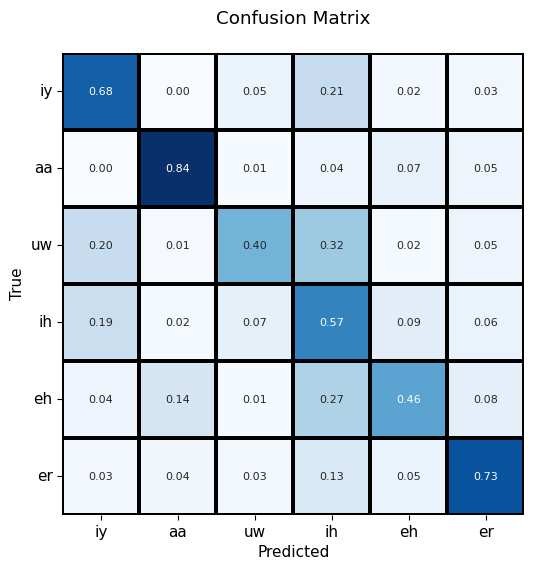

In [21]:
classes=vowel6
downsample=10
#classes=plosives
X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,downsample=downsample)
X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes,downsample=downsample)
print_dataset_statistics(y_train,Details=False,txt="TRAIN")
print_dataset_statistics(y_test,Details=False,txt="TEST")
#
priors = 'uniform'        # priors will not make a big difference for vowel classification, we choose to ignore them here
ng = 8                    # 8 is a reasonable value
nftrs = 13                # common #mfcc coefficients that are used 
Deltas = False             # include delta features as well
max_iter = 4              # for this problem a handful of iterations will be sufficient
######################
# you can modify other training settings by using this **kwargs{}
#  kwargs = dict(verbose=2,verbose_interval=1)   will print loglik-change (per sample) per iteration
#  kwargs = dict(init_params='random')           will change initialization to random instead of KMeans  (more convergence effort is needed)
#  kwargs = dict(reg_cover=1.e-6,tol=1.e-3)      are some other parameters controlling regularization and a stopping criterion for training
#
kwargs =dict(verbose=0,verbose_interval=1,init_params='kmeans')          
################   
acc_train, acc_test, cm = gmm_experiment(X_train,y_train,X_test,y_test,Deltas=Deltas,ng=ng,nftrs=nftrs,Verbose=False)
print("\n==================================================")
print("Accuracy: TRAIN= %.2f%%, TEST= %.2f%%" %(acc_train,acc_test))
print("==================================================")
Spch.plot_confusion_matrix(cm,labels=classes,norm=True,figsize=(6,6),annot_kws={'fontsize':8});

# =========
# DO NOT RUN THE NEXT CELL, SKIP TO RESULTS & QUESTIONS
# =========
## Collecting Experiment Data
For a long time MFCC-39 feature vectors in combination with GMM based modeling formed a baseline system for speech recognition.
The MFCC-39 feature vector consists of 13MFCC coefficients, 13 Delta-MFCCs and 13 Delta-Delta-MFCCs

In the next cell a whole set of experiments with varying feature vector dimensions, using of Deltas or not, varying model size, varying database size,...  
are run.     
All results were captured in a dataframe that is further analyzed in many graphs later on in this notebook.

In [185]:
# modify the 'downsample' factor to control how much data you use for the following experiments
# downsample = 10 ==> use 10% of the data 
# we set a cap on the minimum number of examples per class to avoid training issues
#
classes = vowel6
#classes = plosives
#
# set here the range of parameters that you which to explore
nftrs_exp = [4,8,13,18,24]   # dimension of feature_vector
Deltas_exp = [False,True]    # inclusion of Delta features
ds_exp = [20, 10, 5]         # downsampling factor on the database 
ng_exp = [1,8,64]            # number of gaussians in the model
mincount = 256               # minimum of samples per class to include after downsampling

results = []
# select the subset of classes from the full test set (no downsampling here)
X_test,y_test  = select_subset(X_timit_test,y_timit_test,labels=classes)

for ds in ds_exp:
    X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,
                           downsample=ds,mincount=mincount)
    for Deltas in Deltas_exp:
        for ng in  ng_exp:
            for nftrs in nftrs_exp:
                print("exp[%data,nftrs,Deltas,ngauss]",100./ds,nftrs,Deltas,ng)
                acc_train, acc_test,_ = gmm_experiment(X_train,y_train,X_test,y_test,ng=ng,nftrs=nftrs,Deltas=Deltas)
                results.append([100./ds,Deltas,nftrs,ng,'TRAIN',acc_train])
                results.append([100./ds,Deltas,nftrs,ng,'TEST',acc_test])
                df = pd.DataFrame(results,columns=['%_of_data','Deltas','nftrs','ngauss','train/test','accuracy'])
# add the total number of parameters in the GMM to the dataframe
df['nparam'] = (df['nftrs']*2*(df['Deltas']+1)) *df['ngauss']
df

exp[%data,nftrs,Deltas,ngauss] 5.0 4 False 1
exp[%data,nftrs,Deltas,ngauss] 5.0 8 False 1
exp[%data,nftrs,Deltas,ngauss] 5.0 13 False 1
exp[%data,nftrs,Deltas,ngauss] 5.0 18 False 1
exp[%data,nftrs,Deltas,ngauss] 5.0 24 False 1
exp[%data,nftrs,Deltas,ngauss] 5.0 4 False 8
exp[%data,nftrs,Deltas,ngauss] 5.0 8 False 8
exp[%data,nftrs,Deltas,ngauss] 5.0 13 False 8
exp[%data,nftrs,Deltas,ngauss] 5.0 18 False 8
exp[%data,nftrs,Deltas,ngauss] 5.0 24 False 8
exp[%data,nftrs,Deltas,ngauss] 5.0 4 False 64
exp[%data,nftrs,Deltas,ngauss] 5.0 8 False 64
exp[%data,nftrs,Deltas,ngauss] 5.0 13 False 64
exp[%data,nftrs,Deltas,ngauss] 5.0 18 False 64
exp[%data,nftrs,Deltas,ngauss] 5.0 24 False 64
exp[%data,nftrs,Deltas,ngauss] 5.0 4 True 1
exp[%data,nftrs,Deltas,ngauss] 5.0 8 True 1
exp[%data,nftrs,Deltas,ngauss] 5.0 13 True 1
exp[%data,nftrs,Deltas,ngauss] 5.0 18 True 1
exp[%data,nftrs,Deltas,ngauss] 5.0 24 True 1
exp[%data,nftrs,Deltas,ngauss] 5.0 4 True 8
exp[%data,nftrs,Deltas,ngauss] 5.0 8 True 8


,%_of_data,Deltas,nftrs,ngauss,train/test,accuracy,nparam
0,5.0,False,4,1,TRAIN,56.333870,8
1,5.0,False,4,1,TEST,57.494348,8
2,5.0,False,8,1,TRAIN,60.071122,16
3,5.0,False,8,1,TEST,61.260822,16
4,5.0,False,13,1,TRAIN,62.077295,26
...,...,...,...,...,...,...,...
175,20.0,True,13,64,TEST,70.912299,3328
176,20.0,True,18,64,TRAIN,75.401419,4608
177,20.0,True,18,64,TEST,71.082333,4608
178,20.0,True,24,64,TRAIN,75.267194,6144


## 2. Feature Vector Dimension, Augmentation with Deltas
## +-+-+-+-+-+-+

The graphs below illustrate the recognition rate in function of: 
- number of MFCCs
- Augmentation with Delta features
- modeling detail (# of gaussians)
    
The graphs are illustrations of setups in which 10% of the data is used for training.

#### QUESTIONS (2)
1. *MFCC dimension*:
   - Do you agree/disagree/undecided with following statements:   
       a. The choice of '13' MFCC coefficients gives clearly the best results   
       b. Choosing 8, 13 or 18 MFCC coefficients does not show significant differences.   
   - How do you explain that taking the full 24-D MFCC as feature vector does not yield the best possible performance ?
3. *Use of Deltas*
    - Quantify (as generally as possible) the effect of using Deltas on performance
    - For stationay signals - such as the vowels in this experiment - we may assume that the Delta features equal 0.  This would imply that delta-features for vowels do not yield extra information over the static features.  This seem to contradict the experiment results. Explain.


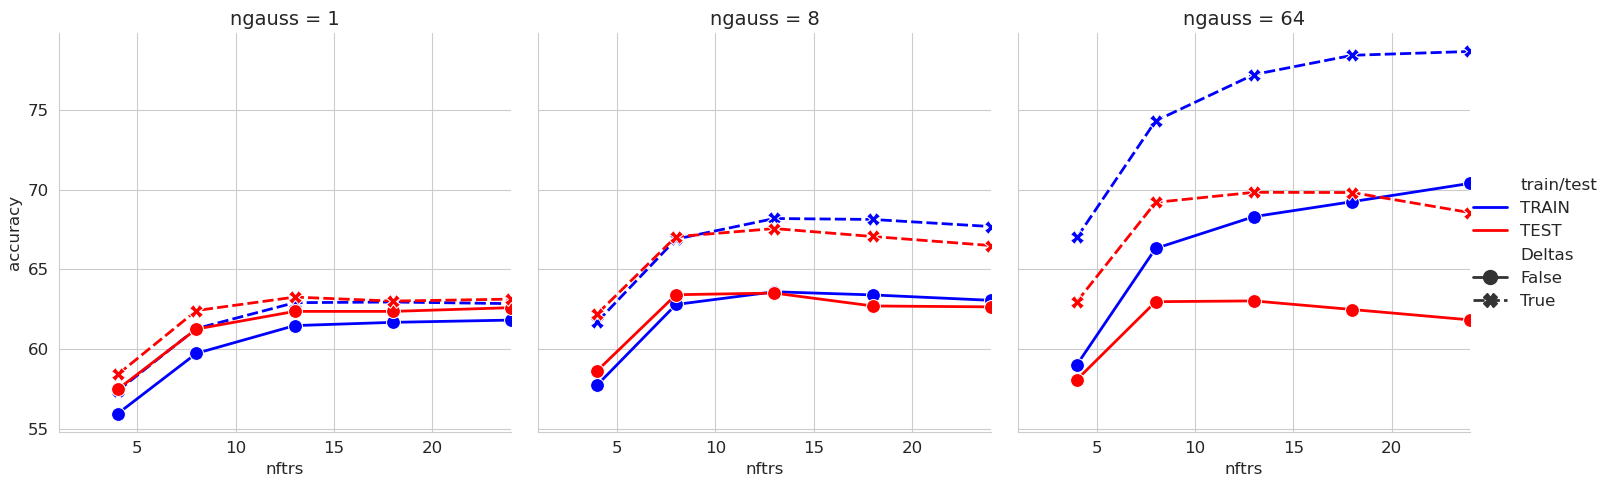

In [213]:
df10 = df[ df['%_of_data']==10.0]
with sns.axes_style('whitegrid'):
    g=sns.relplot(df10,x="nftrs",y="accuracy",hue="train/test",col="ngauss",kind='line',style="Deltas",markers=True,lw=2.,markersize=10)
    g.set(xlim=[1,24])
    g.set_titles(size=14)

## 3. Database Size and Modeling Detail
## +-+-+-+-+-+-+
Based on the results in the previous section, we limit our further analysis to MFCC-26 features (13 static and 13 dynamic coefficients).

We now further analyze the tradeoff between database size and modeling detail.
It is well known that bigger (more detailed) models require more data to get trained.
If "too many model parameters for too few training samples" we will observe "overtraining".  This is generic across all machine learning algorithms. Overtraining will manifest itself as a great discrepancy in performance between TRAIN and TEST set.

In the performed experiments we downsampled the TIMIT database at different rates (5%, 10%, 20%),
simulating the effect of different database sizes.
The main parameter impacting model size is the number of Gaussians that we allow in our model.  
The use of Deltas cou ld be considered another parameter, but its effect is so dominant and consistent that we do not take it into account here.

#### Questions (3)
- Are there clear cases in which overtraining occurs ?
- Identify models where performance saturated with increasing data size
- Choose the most powerful model in your opinion.  Put a maximum on the performance that you expect when the whole dataset would be used for training
- Compute the number of parameters that are trained in the biggest model
- Rate following statements:    
    a. "Adding more gaussians to a model is always a good idea, given that you have enough computing power"
    b. "The best model we have would be helped with more data without the need for adding more parameters to the system" 

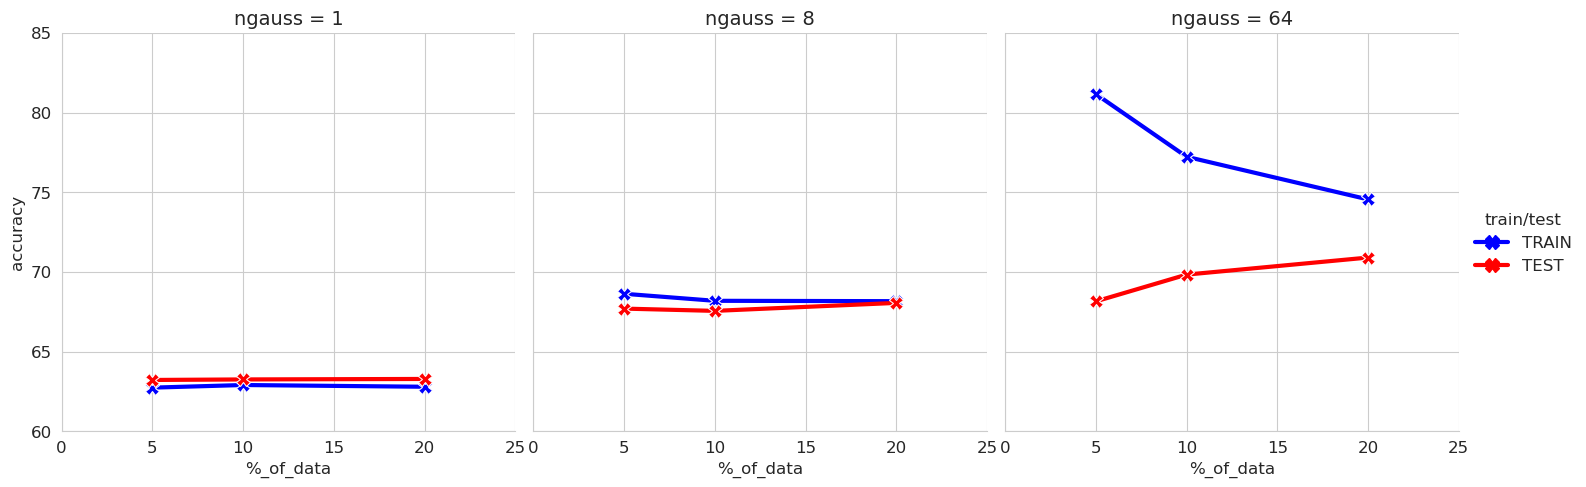

In [186]:
df1 = df[ (df['Deltas']==True) & (df['nftrs'] == 13) ]
with sns.axes_style('whitegrid'):
    g=sns.relplot(df1,x="%_of_data",y="accuracy",hue="train/test",col="ngauss",kind='line',markers=True,lw=3.,marker='X',markersize=10)
    g.set(ylim=[60,85])
    g.set(xlim=[0,25])
    g.set_titles(size=14)

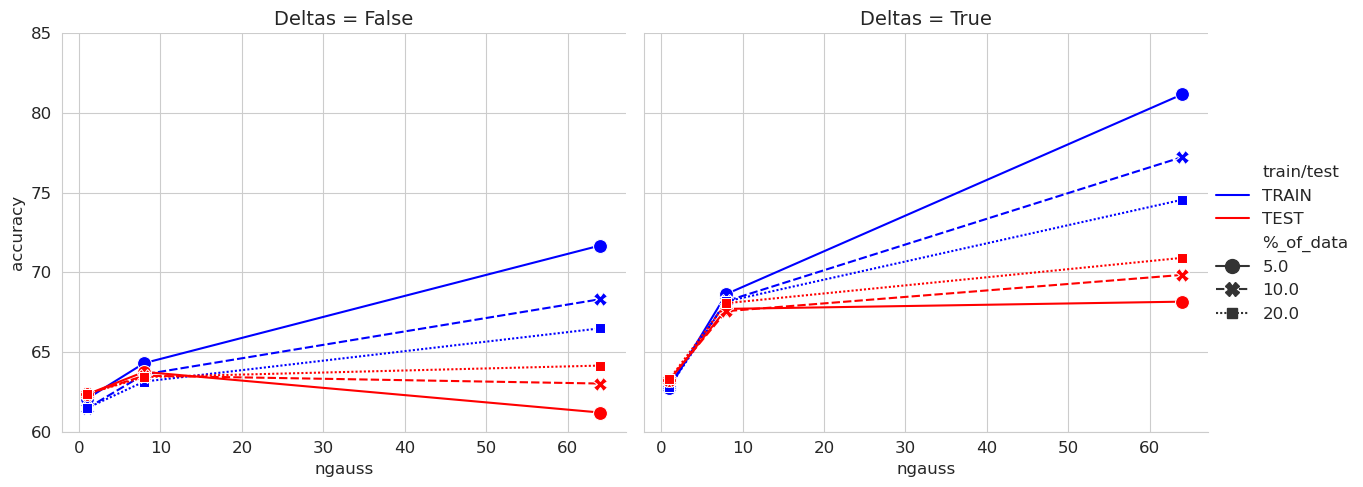

In [212]:
### Performance in function of number of free parameters
df2 = df[ (df['train/test']=='TEST') & (df['nftrs']==13)  ] 
df2 = df[  (df['nftrs']==13)  ] 
with sns.axes_style('whitegrid'):
    g=sns.relplot(df2,x="ngauss",y="accuracy",kind='line',col='Deltas',style='%_of_data',hue='train/test',markers=True,markersize=10,aspect=1.25)
    g.set(ylim=[60,85])
    g.set_titles(size=14)

# REST OF THE NOTEBOOK IS UNDER DEVELOPMENT

### Exercise 2: Experiments with all phonemes

We are now doing some similar experiments with all phonemes.
For experiment's sake we are using 10% of the database.
We have precomputed training/test results for variable feature sets (with and without Delta's)  and variable number of Gaussians.  This is shown in the table below
Small random deviations in performance results are possible due to hardware, random number initializations, ... 

#### QUESTIONS
1. You see a fabulous increase (for train accuracy) when going from 16 to 64 Gaussians in the table
   - How do you explain this ?
   - Do you expect the same spectacular improvement when evaluating on the independent test set ?
   - Could your conclusions be different if you were to use the FULL TIMIT data set for training ?
  
Note: We obtained 56% frame accuracy when training a 64 mixture on the full timit database.

In [119]:
res1 =  [ [False,1,43.8,42.8], [False,4,45.4,44.1] , [False,16,48.1,44.9] , [False,64,53.9,np.NaN] , [True,1,47.2,46.3], [True,4,51.1,50.0], [True,16,56.7,52.5], [True,64,67.0,np.NaN] ]
res1_df = pd.DataFrame(res1,columns=['Deltas','ng','Train_Acc','Test_Acc'])
res1_df

,Deltas,ng,Train_Acc,Test_Acc
0,False,1,43.8,42.8
1,False,4,45.4,44.1
2,False,16,48.1,44.9
3,False,64,53.9,NaN
4,True,1,47.2,46.3
5,True,4,51.1,50.0
6,True,16,56.7,52.5
7,True,64,67.0,NaN


#### QUESTIONS
Now run an additional experiment (cell below) while using 8 Gaussians and have a look at the confusion matrix.
   
- Confusable pairs ?
    + Which are the most confusable pairs in the confusion matrix ?   
    + Do you understand why they are confusable ?
    + Look at the pair (s,z).  It's not surprising that these are confusable.  What is remarkable, however, if you look in detail ?
- If you change the priors from 'training' (i.e. trained priors) to 'uniform' (all phonemes equally probable) what will happen ?   
    + the gobal error rate will INCREASE / DECREASE ?   
    + the error rate on the worst performing phoneme will INCREASE / DECREASE ?   
    + the error rate on the least frequent phoneme will INCREASE / DECREASE ?

In [ ]:
classes = timit41
downsample = 10
mincount = 256
X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,
                           downsample=downsample,mincount=mincount)

X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes,
                           downsample=downsample,mincount=mincount)
#
# set here the range of parameters that you which to explore
#  ng: number of gaussians
nftrs=13
ng_exp = [8]
Deltas_exp = [True]
results = []
for Deltas in Deltas_exp:
    for ng in  ng_exp:
        print("exp[nftrs,Deltas,ngauss]",nftrs,Deltas,ng)
        acc_train, acc_test, cm = gmm_experiment(X_train,y_train,X_test,y_test,ng=ng,nftrs=nftrs,Deltas=Deltas)
        results.append([Deltas,ng,'TRAIN',acc_train])
        results.append([Deltas,ng,'TEST',acc_test])
        results_df = pd.DataFrame(results,columns=['Deltas','ngauss','train/test','accuracy'])
print(results_df)

In [ ]:
Spch.plot_confusion_matrix(cm,labels=classes,norm=True,figsize=(16,16),annot_kws={'fontsize':7});

## Exercise 3.  Training an MLP Classifier

#### PRELIMINARY NOTE
Training Neural Nets requires computer power.  The implementation here is not intended for large training examples or complex models as it is CPU-only.  We use the sklearn toolkit here for its similarity in API with the GMM models.     
Training single layer networks may go fast, a couple of minutes at most.
Working with 2 and more layers really requires time !
So in practice we are limited to testing nets with 2 hidden layers at most and generally speaking with 10% of the data at most.
This obviously doesn't show the full potential, but notebooks are for quick turnaround and not for heafty training setups.

A few results were saved to the notebook below

In [ ]:
classes = vowel6 #timit41
downsample = 10
mincount = 256

# ----- extra parameters that can be changed, but might be fine for most tests
max_iter = 500  # maximum number of iterations in the backpropagation algorithm
momentum = 0.9  # only for SGD
early_stopping = True
validation_fraction = 0.1

hidden_layers_test = [(256) , (1024), (512,512) ] # , (512) , (1024), (512,512) , (256,256,256) ]  # network configurations
learning_rate_test = [ 0.005 ]   # initial learning rates for the network training
Deltas_test = [True, False]
ds_test = [ 100, 50, 20, 10]
results = []

for ds in ds_test:
  X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,
                           downsample=ds,mincount=mincount)
  X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes,
                           downsample=ds,mincount=mincount)    
  for Deltas in Deltas_exp:
    for hidden_layer_sizes in hidden_layers_test:
        for learning_rate_init in learning_rate_test:
            clf_MLP = MLPClassifier(solver='adam', 
                                    learning_rate_init=learning_rate_init,
                                    hidden_layer_sizes=hidden_layer_sizes,
                                    max_iter=max_iter, alpha=1e-5, random_state=1,
                                    early_stopping=early_stopping,
                                    validation_fraction=validation_fraction)
            clf_MLP.fit(X_train,y_train)

            #print("*** feature_type(dim=%d), hidden layers=%s, lr=%.5f ***" %       (n_dim,hidden_layer_sizes,learning_rate_init))
            y_pred = clf_MLP.predict(X_train)
            train_acc = 100.0*skmetrics.accuracy_score(y_train, y_pred)
            # print('Train Set Accuracy: %.2f%%' % (100.0*train_acc))
            y_pred = clf_MLP.predict(X_test)
            test_acc = 100.0*skmetrics.accuracy_score(y_test, y_pred)
            cmat = skmetrics.confusion_matrix(y_test,y_pred)

            # 3. print and save results            
            print('layers=%s   lr=%.5f     Train Accuracy:%.2f%%    Test Accuracy: %.2f%%' % (hidden_layer_sizes,learning_rate_init,train_acc,test_acc))
            results.append([100./ds,Deltas,nftrs,str(hidden_layer_sizes), 'TRAIN',train_acc])
            results.append([100./ds,Deltas,nftrs,str(hidden_layer_sizes), 'TEST',test_acc])            


results_df = pd.DataFrame(results,columns=['pct_data','Deltas','nftrs','layers','train/test','accuracy'])
print(results_df)

In [ ]:
results_df

In [ ]:
colors=['r','g','b','k','c','m','y']
cmap = sns.color_palette(colors)
sns.set_palette(cmap)
kwargs = {'linewidth':2,'markersize':10,'markers':True}
fig,ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
#df = results_df[ results_df['train/test']=='TEST']

sns.lineplot(data=results_df,x='pct_data',y='accuracy',ax=ax[0],style='layers',hue='train/test',**kwargs);
ax[0].set_title("Test set accuracy vs. pct_data ")
ax[0].grid(linestyle='--')
#hues = map(str,df['ngauss'].tolist())
#sns.lineplot(data=df,x='ngauss',y='accuracy',style='pct_data',ax=ax[1],color='b',**kwargs);
#ax[1].set_title("Test set accuracy vs. ngauss ")
#ax[1].grid(linestyle='--');

## Exercise 4: Using the models in Continuous Speech Recognition

In this part we will use the trained models to compute frame probabilities (likelihoods or posteriors) for an utterance.
Computing these frame probabilities is just a first step towards continuous speech recognition.  
We can evaluate frame recognition rate within a sentence.   
Also we can observe how stable / unstable such observation probabilities are over time.

##### Note on transcriptions and labels
NOTE 1.
One of the labels is 'cl', i.e. closure before a plosive.  These are often present in your transcriptions, e.g.
-  bricks: b r ih cl k s

NOTE 2.
The transcriptions in TIMIT are labels as given by humans listening to very short fragments of an utterance.   Their transcription reflect the sound that they here .  Thus it is NOT a  CANONICAL transcription which is the transcription you find in a dictionary.
As such you may encounter pronunciation variants:
- is: ih s
- is: iy z

##### Questions.
Question 1:
- Select example 2 ("bricks")
- Have a look at the frame probabilites
    + where does the recognizer seems fairly certain
    + assuming  you only have these prob's as your input (i.e. this is what a recognizer gets), what word would you form if you only take into accounts segments of a couple frames that are consistently recognized as the same phone?
    
Question 2:
- Give an example of phonetic confusion that in your opinion will probably not hurt the recognizer when it can use lexical information

In [ ]:
# utilities for saving and retrieving models from pickle files
def save_pickle(data,filename):
    picklefile = open(filename, 'wb')
    pickle.dump(data, picklefile),
    picklefile.close()    
def get_pickle(filename):
    picklefile = pyspch.read_fobj(filename)    
    data = pickle.load(picklefile)
    picklefile.close()
    return(data)

# plot utilities
def plot_probs(probs, labels,  fig, iax=2, x0=0.,vmin=None, title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## 
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,vmin=vmin,linewidths=1,linecolor='k',cbar_kws={'pad':0.0})
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.],color=None)   # defaults to blue for all lines if not specified
        fig.axes[iax].legend(labels, loc='center right', fontsize='x-small') # bbox_to_anchor=(1.00,.5))  # , ncol=15)
    ax.set_title(title)

In [ ]:
timit_root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'
classes = timit41
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}

# select a test file for analysis
#################################
example = 2
test_files = ['test/dr1/faks0/si2203',  'test/dr8/fcmh1/si1493', 'test/dr4/fadg0/si1279', 'train/dr1/fcjf0/sx307', 'train/dr1/fdaw0/sx236'] #,'train/dr1/fdml0/si1779']
name = test_files[example]
if name == 'test/dr1/faks0/si2203':    # segment selection "for this dive"
    transcrition = "the reasons for this dive are foolish by now"
    segment_transcription = "for this dive"
    phn_sel = np.array(['sil','cl','d','dh','z','s','f','v','r','er','aa','ay','ah','ao','ih']) #'sil','iy','aa','cl'
    frames=[132,209] # [150,250] # #  [160,185]   # [250,350] # 
elif name ==  'test/dr8/fcmh1/si1493':  # segment selection "by that time perhaps something "
    phn_sel = np.array(['sil','cl','b','dh','t','p','s','m','ay','aa','ae','ah','iy','th'])
    phn_sel = np.array(['sil','cl','b','dh','t','p','ay','aa','ae','ah','eh'])
    frames=[10,65]
elif name == 'test/dr4/fadg0/si1279':  # bricks are an alternative
    transcription = "bricks are an alternative"
    segment_transcription = "bricks"
    phn_sel = np.array(['sil','b','r','ih','cl','k','s','dh','t','iy','ae','eh','ey','z'])
    frames = [10,50]
elif name == 'train/dr1/fcjf0/sx307': # the meeting is now adjourned
    transcription = "the meeting is now adjourned"
    segment_transcription = "the meeting is now"
    phn_sel = np.array(['sil','ih','iy','ey','aw','ay','dh','t','s','f','z','ng','n','m']) 
    frames = [5,80]
elif name == 'train/dr1/fdaw0/sx236': # clear pronunciation is appreciated
    transcription = "clear pronunciation is appreciated"
    segment_transcription = "is appreciated"
    phn_sel = np.array(['sil','cl','ah','aw','ae','eh','ey','ih','iy','uh','b','d','dh','p','t','k','r','l','s','sh','ng','n','m'])
    frames = [160,250]
else:
    phn_sel = phnset
    frames = [0,-1]
#
shift = 0.01
indx_sel = [classes.index(phn) for phn in phn_sel]
frame_sel = slice(frames[0],frames[1])
x0 = (frames[0]+.5)*shift

# audio and feature extraction
example_audio, sample_rate = pyspch.audio.load(timit_root + 'audio/' + name + ".wav")
example_spg = pyspch.sp.feature_extraction(example_audio, sample_rate=sample_rate) #, **setup.feature_args)
example_features = pyspch.sp.feature_extraction(example_audio, **feature_args)
# transcription + word segmentation 
# transcription + word segmentation 
example_txt = pyspch.read_txt(timit_root + 'segmentation/' + name + ".txt")
example_wrd = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".wrd", dt=1/sample_rate)
print(example_txt)    
# get reference segmentation and labels , phone segmentation (+ as index)
example_phn = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".phn", fmt="float32", dt=1/sample_rate,xlat='timit61_timit41')
example_lab = pyspch.seg2lbls(example_phn, n_frames=example_features.shape[1],pad_lbl='sil') 

In [ ]:
# Import a model or reuse one of the models that you have trained above
#######################################################################
timit_models = "https://homes.esat.kuleuven.be/~spchlab/data/timit/models/gmm/"
# clf_test = get_pickle("GMM_TIMIT_MINI_D26_G8.pk")   # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
clf_test = get_pickle(timit_models+"S41_D26_G64_FULL_1.pkl")   # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
classes = clf_test.classes

In [ ]:
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,
                            frames=frames, sample_rate=sample_rate, figsize=(15,6), img_ftrs=[example_features])
fig.add_seg_plot(example_phn, iax=1, ypos=.15, color='k') 
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=example_audio,rate=sample_rate))

In [ ]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
postprob_gmm = clf_test.predict_proba(X=example_features.T)
# evaluate frame based recognition wrt. manual segmentations
y_gmm_idx = np.argmax(postprob_gmm, axis=1)
y_gmm_lab = [classes[i] for i in y_gmm_idx]
# alternative
# y_gmm_lab = clf_GMM.predict(X=example_features.T)
y_gmm_seg = pyspch.lbls2seg(y_gmm_lab)
n_corr = np.sum([y_gmm_lab[i] == example_lab[i] for i in range(len(example_lab))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(example_lab)))

In [ ]:
# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,row_heights=[1.5,2,4,4,.75],
                                 frames=frames, sample_rate=sample_rate, figsize=(15,10), img_ftrs=[None,None])
fig.add_seg_plot(example_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*.01, style="img", title="GMM Posterior Probs")
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*.01, style="line", title="GMM Posterior Probs")

fig.add_seg_plot(y_gmm_seg, iax=4, ypos=.25, Lines=True, color='k') # predicted labels
fig